In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

Number Of Players    :  15
Number Of Images     :  576


Distribution Per Player


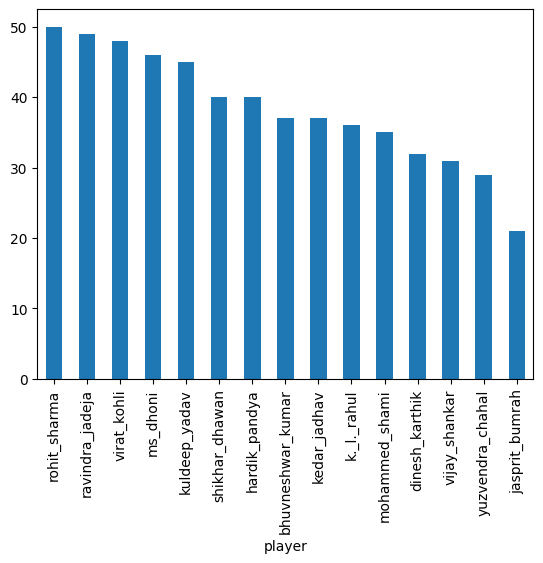

In [2]:
ds = pd.read_csv("/content/sample_data/players.csv")
ds = ds.sample(frac=1).reset_index(drop=True)

le = preprocessing.LabelEncoder()
le.fit(ds['player'])
ds['player_trans'] = le.transform(ds['player'])

n = int(len(ds))
players = ds.player.nunique()
print("Number Of Players    : ",players)
print("Number Of Images     : ",n)
print("\n\nDistribution Per Player")
ds['player'].value_counts().plot.bar()

ds = ds[:-6]
test = ds[-6:]

Distribution Per Player


<Axes: xlabel='player'>

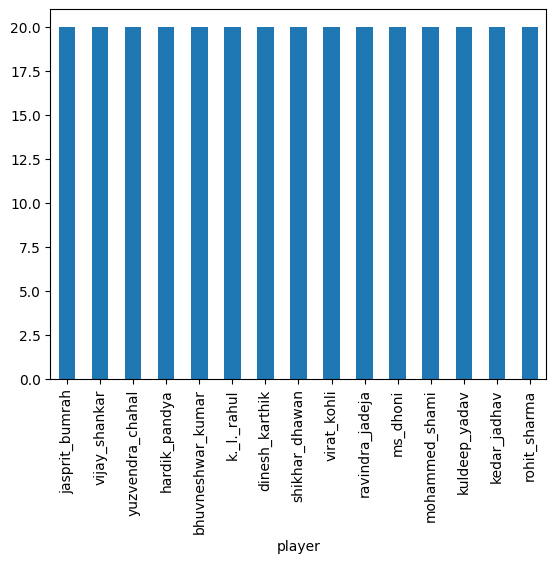

In [3]:
for index,row in ds.iterrows():
    if len(ds[ds['player']==row['player']])>20:
        ds.drop(ds[ds['image']==row['image']].index , inplace=True)

print("Distribution Per Player")
ds['player'].value_counts().plot.bar()

In [10]:
import glob
file = '/content/sample_data/*.jpg'
images = glob.glob(file)
len(images)

37

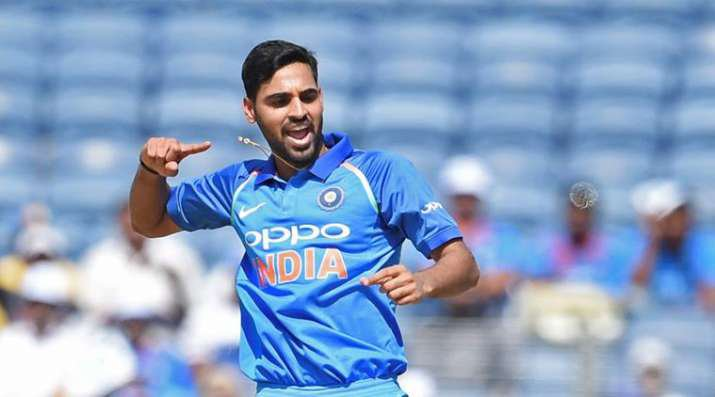

In [11]:
import PIL
PIL.Image.open(str(images[0]))

In [12]:
batch_size = 32
img_height = 180
img_width = 180

In [13]:
data_dir = '/content/sample_data/data_dir'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 69 files belonging to 2 classes.
Using 56 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 69 files belonging to 2 classes.
Using 13 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['bhuvneshwar_kumar', 'dinesh_karthik']


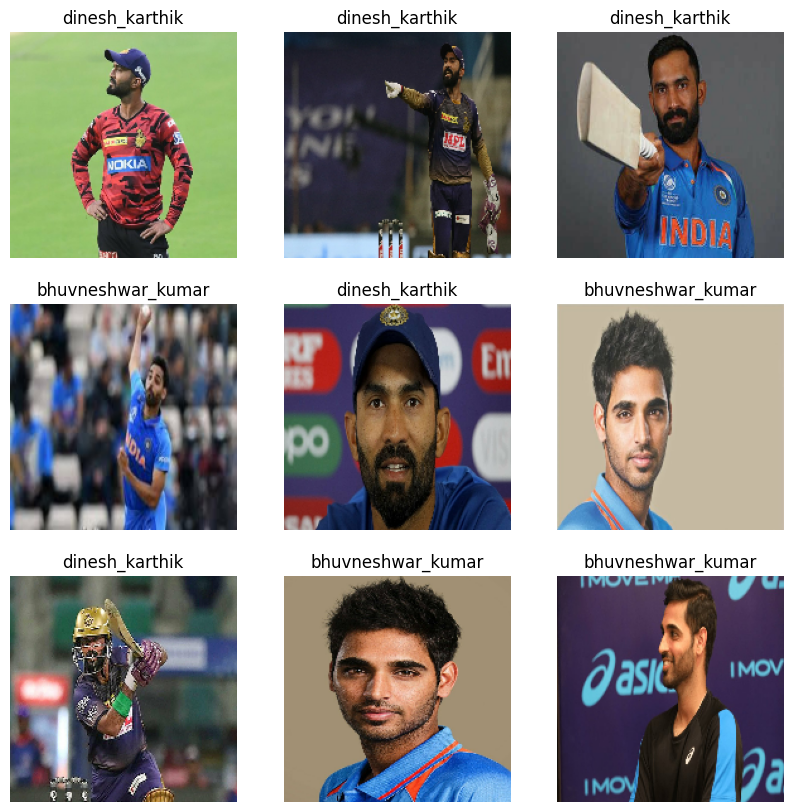

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [21]:
normalization_layer = layers.Rescaling(1./255)

In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9986929


In [23]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5774 - loss: 2.5111 - val_accuracy: 0.4615 - val_loss: 1.0894
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4266 - loss: 1.2595 - val_accuracy: 0.5385 - val_loss: 1.0561
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 881ms/step - accuracy: 0.4226 - loss: 1.1333 - val_accuracy: 0.5385 - val_loss: 0.7217
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4901 - loss: 0.6786 - val_accuracy: 0.5385 - val_loss: 0.6883
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8532 - loss: 0.6442 - val_accuracy: 0.5385 - val_loss: 0.6875
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6726 - loss: 0.6277 - val_accuracy: 0.6154 - val_loss: 0.6714
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9127 - loss: 0.5859 - val_accuracy: 0.6154 - val_loss: 0.6759
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8651 - loss: 0.5210 - val_accuracy: 0.5385 - val_loss: 0.7055
Epoch 9/10
2/

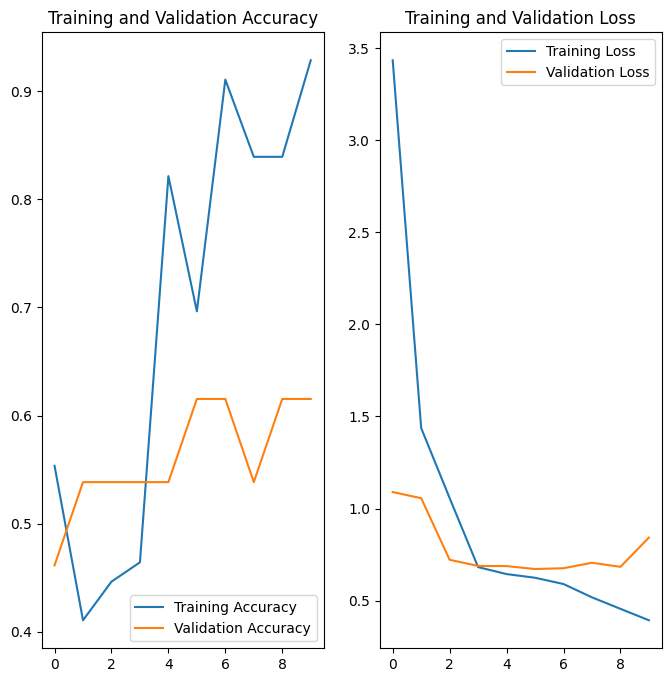

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

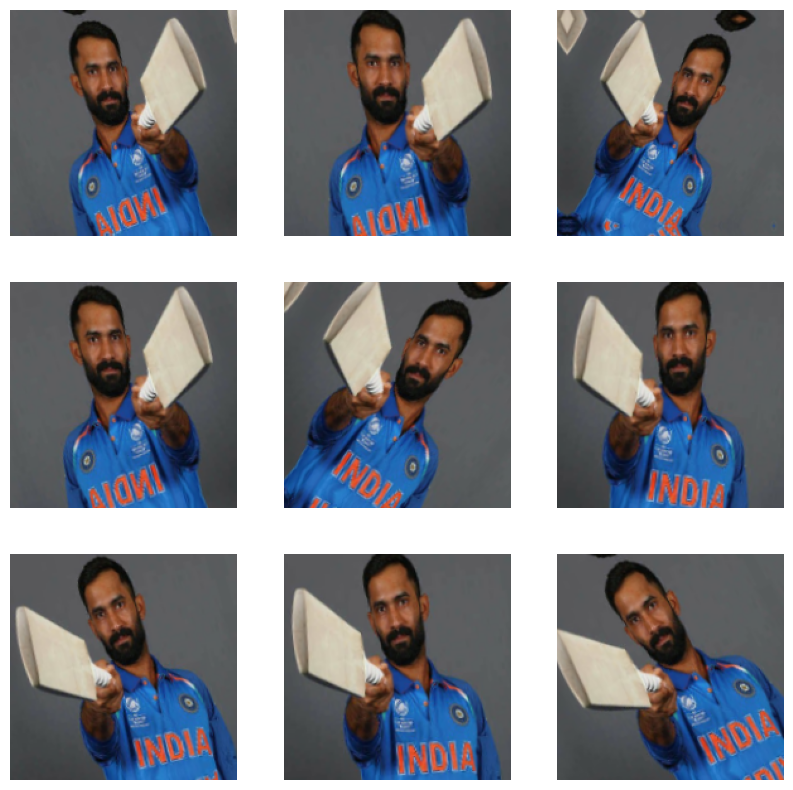

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5774 - loss: 1.5577 - val_accuracy: 0.4615 - val_loss: 0.9358
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4266 - loss: 0.9060 - val_accuracy: 0.5385 - val_loss: 0.7963
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4226 - loss: 0.8503 - val_accuracy: 0.5385 - val_loss: 0.7114
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4782 - loss: 0.7011 - val_accuracy: 0.5385 - val_loss: 0.6892
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5020 - loss: 0.6850 - val_accuracy: 0.6923 - val_loss: 0.6840
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7619 - loss: 0.6783 - val_accuracy: 0.6154 - val_loss: 0.6812
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8274 - loss: 0.6737 - val_accuracy: 0.6154 - val_loss: 0.6716
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7639 - loss: 0.6650 - val_accuracy: 0.7692 - val_loss: 0.6558
Epoch 9/15
2/2 ━

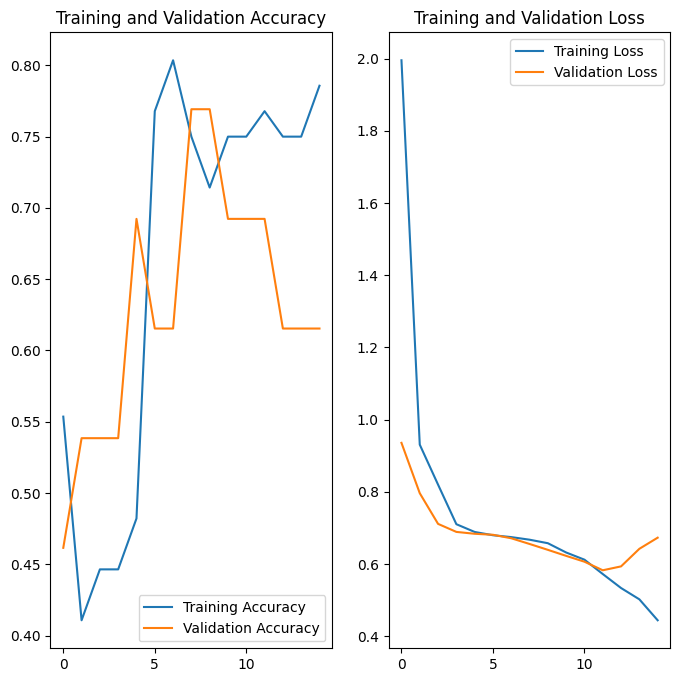

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
import tensorflow as tf

# Path to your local image file
local_image_path = "/content/sample_data/data_dir/new_images/0389b4a1bc.jpg"

# Read the image from the local path
image = tf.io.read_file(local_image_path)

# Decode the image to a tensor
image = tf.image.decode_jpeg(image, channels=3)  # for JPEG images (use decode_png for PNG images)

# Optionally resize the image if needed
image = tf.image.resize(image, [180, 180])

# Print the image shape
print(f"Image shape: {image.shape}")

Image shape: (180, 180, 3)


In [50]:
img_array = tf.keras.utils.img_to_array(image)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
This image most likely belongs to bhuvneshwar_kumar with a 97.17 percent confidence.
